In [3]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
#from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

#from imblearn.over_sampling import SMOTE




      Status Application Creation Date Approved / Refused Date  \
0   Recorded                12/07/2013              24/07/2013   
2   Recorded                30/04/2009              13/07/2009   
3   Recorded                13/04/2018              26/04/2018   
7   Recorded                29/11/2018              29/11/2018   
17  Recorded                08/10/2009              08/10/2009   

   Recorded / Rejected Date Water Share ID Water System Source Reliability  \
0                23/08/2013      WEE****24            Goulburn        High   
2                11/09/2009      WEE****80            Goulburn         Low   
3                01/05/2018      WEE****36            Goulburn        High   
7                14/12/2018      WEE****60            Goulburn        High   
17               09/11/2009      WEE****06            Goulburn        High   

    Trading Zone Source Seller Water Authority Seller Trading Zone Use  \
0   1A Greater Goulburn  Goulburn-Murray Water     1A Greate

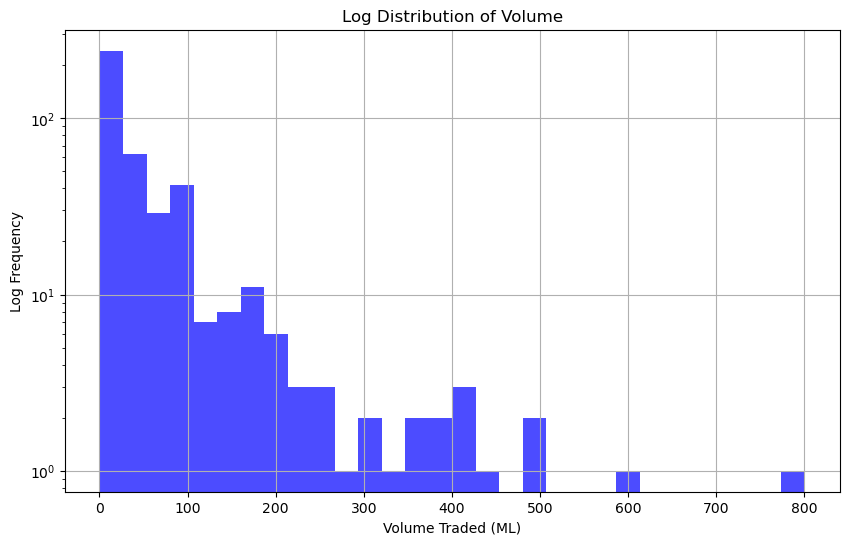

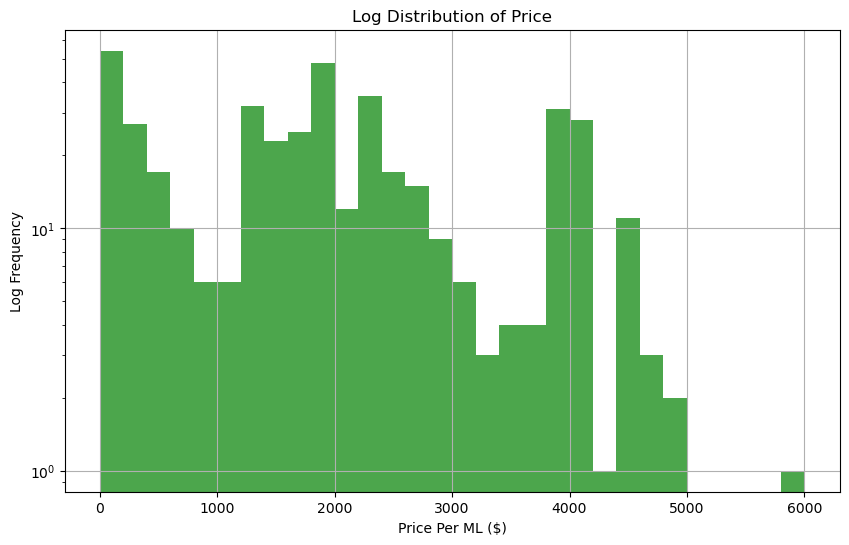

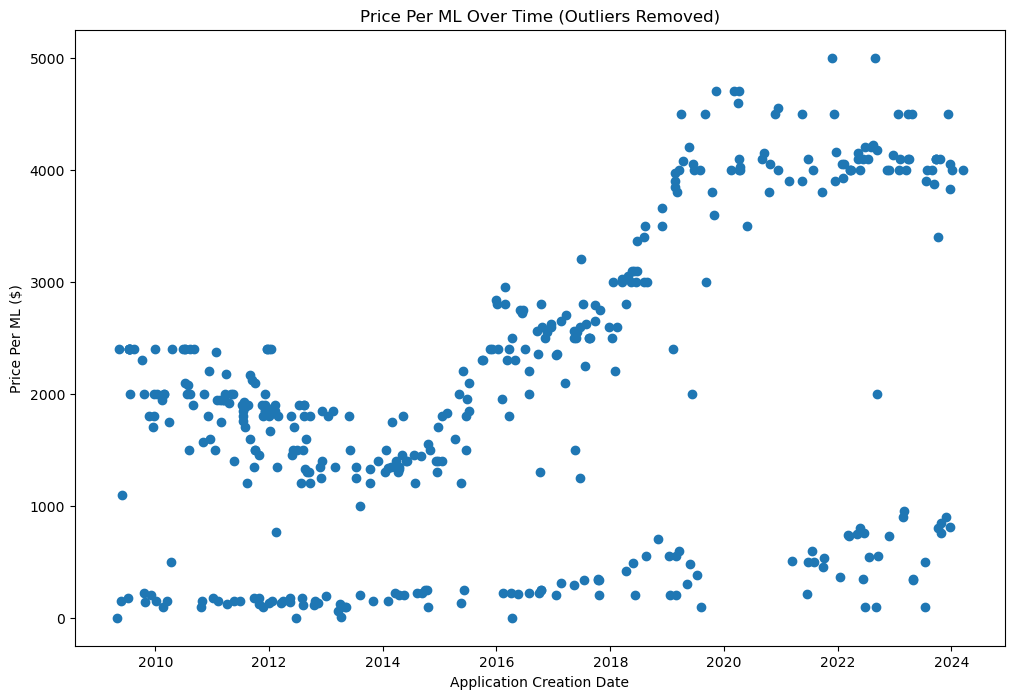

In [29]:
# Load water market data from CSV files
water_market_data = pd.read_csv('./data/ALL_water_share_trading.csv', parse_dates=['Application Creation Date'], nrows=1500)

#water_market_data = water_market_data.dropna()
water_market_data = water_market_data[(water_market_data['Price Per ML ($)']!=0)&(water_market_data['Water System Source']=="Goulburn")&(water_market_data["Status"]=="Recorded")]
# Convert date to datetime
water_market_data = water_market_data.assign(Date=pd.to_datetime(water_market_data['Application Creation Date'], format="%d/%m/%Y"))
# Check the first few rows of the data
print(water_market_data.head())

# Summary statistics for the numerical data
print(water_market_data.describe())

# Plotting the log distribution of the 'Volume' column
plt.figure(figsize=(10, 6))
plt.hist(water_market_data['Volume Traded (ML)'], bins=30, color='blue', alpha=0.7, log=True)
plt.title('Log Distribution of Volume')
plt.xlabel('Volume Traded (ML)')
plt.ylabel('Log Frequency')
plt.grid(True)
plt.show()

# Plotting the log distribution of the 'Price' column
plt.figure(figsize=(10, 6))
plt.hist(water_market_data['Price Per ML ($)'], bins=30, color='green', alpha=0.7, log=True)
plt.title('Log Distribution of Price')
plt.xlabel('Price Per ML ($)')
plt.ylabel('Log Frequency')
plt.grid(True)
plt.show()


# Plotting the 'Price Per ML ($)' over time using a scatter plot after removing outliers
plt.figure(figsize=(12, 8))
# Calculate the interquartile range to determine outliers
Q1 = water_market_data['Price Per ML ($)'].quantile(0.25)
Q3 = water_market_data['Price Per ML ($)'].quantile(0.75)
IQR = Q3 - Q1
# Filter out the outliers
filtered_data = water_market_data[(water_market_data['Price Per ML ($)'] >= (Q1 - 1.5 * IQR)) & (water_market_data['Price Per ML ($)'] <= (Q3 + 1.5 * IQR))]
plt.scatter(filtered_data['Date'], filtered_data['Price Per ML ($)'])
plt.title('Price Per ML Over Time (Outliers Removed)')
plt.xlabel('Application Creation Date')
plt.ylabel('Price Per ML ($)')
#plt.grid(True)
plt.show()


Colouring the datapoints by the "reliability" of the water share reveals that it is responsible for the apparent clustering.

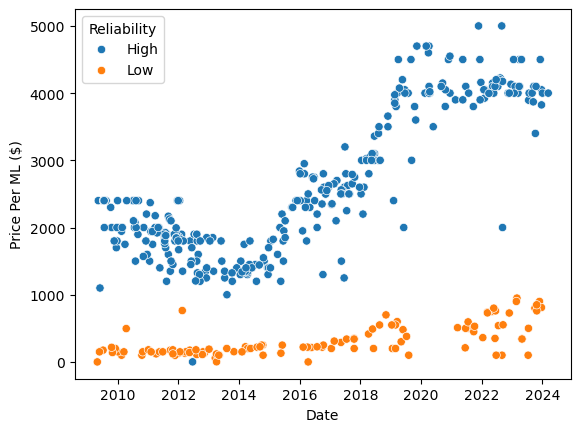

<AxesSubplot: xlabel='Date', ylabel='Price Per ML ($)'>

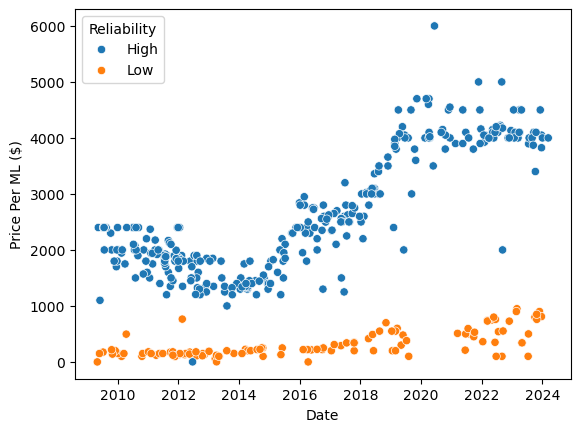

In [32]:
import seaborn as sns

sns.scatterplot(filtered_data, x="Date", y="Price Per ML ($)", hue="Reliability")
plt.show()
sns.scatterplot(water_market_data, x="Date", y="Price Per ML ($)", hue="Reliability")

Class
0    750
1    750
Name: count, dtype: int64
Accuracy: 0.49
Confusion Matrix:
[[147   1]
 [152   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.99      0.66       148
           1       0.00      0.00      0.00       152

    accuracy                           0.49       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.24      0.49      0.32       300



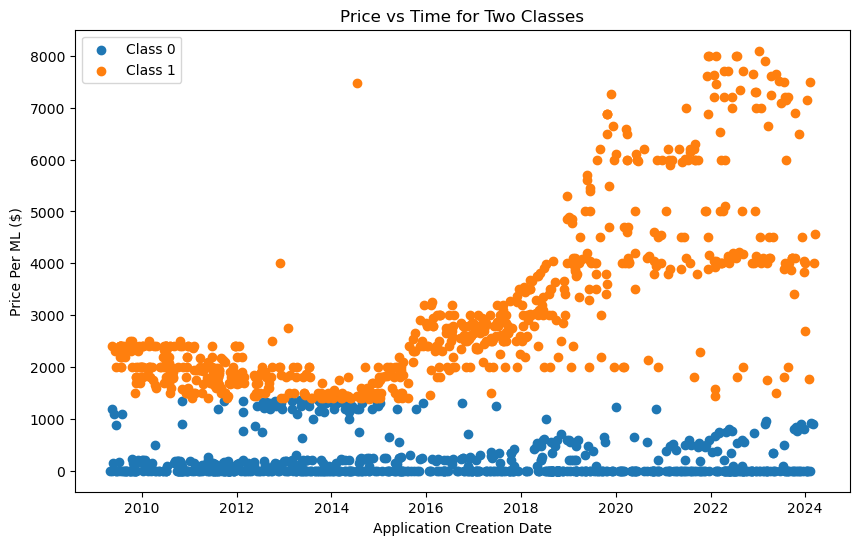

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate the median of the 'Price Per ML ($)' column
median_price = water_market_data['Price Per ML ($)'].median()

# Create two classes: 0 for prices below or equal to the median, 1 for prices above the median
water_market_data['Class'] = (water_market_data['Price Per ML ($)'] > median_price).astype(int)

# Check the distribution of the new classes
print(water_market_data['Class'].value_counts())

# Assuming 'Class' is the target variable and 'Volume Traded (ML)' is the feature
X = water_market_data[['Volume Traded (ML)']]
y = water_market_data['Class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying nonlinear SVM classification with a polynomial kernel
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train_scaled, y_train)

# Predicting the test set results
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

import matplotlib.pyplot as plt

# Convert 'Application Creation Date' to datetime if not already done
if not pd.api.types.is_datetime64_any_dtype(water_market_data['Application Creation Date']):
    water_market_data['Application Creation Date'] = pd.to_datetime(water_market_data['Application Creation Date'], dayfirst=True)

# Plotting price vs time for the two classes using scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
for label, group in water_market_data.groupby('Class'):
    ax.scatter(group['Application Creation Date'], group['Price Per ML ($)'], label=f'Class {label}')
ax.set_title('Price vs Time for Two Classes')
ax.set_xlabel('Application Creation Date')
ax.set_ylabel('Price Per ML ($)')
ax.legend()
plt.show()


In [14]:
pd.to_datetime(water_market_data['Application Creation Date'], format="%d/%m/%Y")

0      2013-07-12
1      2020-01-06
2      2009-04-30
3      2018-04-13
4      2022-09-09
          ...    
1494   2016-12-02
1496   2015-12-04
1497   2011-05-16
1498   2015-08-17
1499   2017-12-01
Name: Application Creation Date, Length: 1057, dtype: datetime64[ns]

In [13]:
water_market_data['Application Creation Date'].head(10)

0     12/07/2013
1     06/01/2020
2     30/04/2009
3     13/04/2018
4     09/09/2022
6     25/06/2015
7     29/11/2018
9     14/06/2018
10    03/04/2014
11    16/10/2013
Name: Application Creation Date, dtype: object

In [17]:
water_market_data.columns

Index(['Status', 'Application Creation Date', 'Approved / Refused Date',
       'Recorded / Rejected Date', 'Water Share ID', 'Water System Source',
       'Reliability', 'Trading Zone Source', 'Seller Water Authority',
       'Seller Trading Zone Use', 'Buyer Water Authority',
       'Buyer Trading Zone Use', 'Volume Traded (ML)', 'Price Per ML ($)',
       'Date'],
      dtype='object')

In [24]:
water_market_data

,Status,Application Creation Date,Approved / Refused Date,Recorded / Rejected Date,Water Share ID,Water System Source,Reliability,Trading Zone Source,Seller Water Authority,Seller Trading Zone Use,Buyer Water Authority,Buyer Trading Zone Use,Volume Traded (ML),Price Per ML ($),Date
0,Recorded,12/07/2013,24/07/2013,23/08/2013,WEE****24,Goulburn,High,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,17.4,1250.00,2013-07-12
2,Recorded,30/04/2009,13/07/2009,11/09/2009,WEE****80,Goulburn,Low,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,13.4,0.07,2009-04-30
3,Recorded,13/04/2018,26/04/2018,01/05/2018,WEE****36,Goulburn,High,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,1.0,2800.00,2018-04-13
7,Recorded,29/11/2018,29/11/2018,14/12/2018,WEE****60,Goulburn,High,1B Boort,Goulburn-Murray Water,1B Boort,Goulburn-Murray Water,1B Boort,20.0,3500.00,2018-11-29
17,Recorded,08/10/2009,08/10/2009,09/11/2009,WEE****06,Goulburn,High,1B Boort,Goulburn-Murray Water,1B Boort,Goulburn-Murray Water,1B Boort,1.0,2300.00,2009-10-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,Recorded,19/02/2019,26/02/2019,13/03/2019,WEE****41,Goulburn,High,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,75.0,3850.00,2019-02-19
1487,Recorded,10/09/2014,02/10/2014,10/10/2014,WEE****75,Goulburn,Low,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,5.8,225.00,2014-09-10
1488,Recorded,11/06/2012,19/06/2012,13/07/2012,WEE****98,Goulburn,High,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,52.0,1700.00,2012-06-11
1489,Recorded,21/07/2009,27/07/2009,23/09/2009,WEE****82,Goulburn,High,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,Goulburn-Murray Water,1A Greater Goulburn,170.0,2400.00,2009-07-21
